# Markov Chain Monte Carlo Example 1
Author: Audrey Olivier, Dimitris G. Giovanis, Michael D. Shields <br>
Last modified: May 2020 by Audrey Olivier

In this example, the Metropolis-Hastings is employed to generate samples from a Rosenbrock distribution. The method illustrates various aspects of the UQpy MCMC class:
- various ways of defining the target pdf to sample from,
- definition of input parameters required by the algorithm (proposal_type and proposal_scale for MH),
- running several chains in parallel,
- call diagnostics functions.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the MCMC class from UQpy.

In [1]:
from UQpy.sampling import MetropolisHastings
import numpy as np
import matplotlib.pyplot as plt
import time

## Explore various ways of defining the target pdf

Define the Rosenbrock probability density function up to a scale factor. Here the pdf is defined directly in the python script <br>
- define the Rosenbrock probability density function up to a scale factor, this function only takes as input parameter the point x where to compute the pdf, <br>
- define a pdf function that also takes as argument a set of parameters params,
- define a function that computes the log pdf up to a constant.
Alternatively, the pdf can be defined in an external file that defines a distribution and its pdf or log_pdf methods (Rosenbrock.py)

In [2]:
def rosenbrock_no_params(x):
     return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)
    
def log_rosenbrock_with_param(x, p):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/p)

(500, 2)


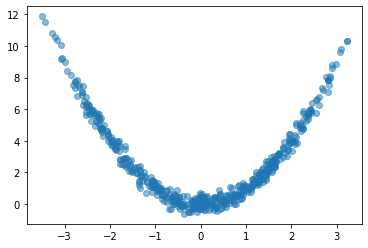

In [3]:
from UQpy.sampling.input_data import MhInput

mh_input = MhInput(dimension=2, pdf_target=rosenbrock_no_params, burn_length=500, jump=50, chains_number=1)
x = MetropolisHastings(mh_input=mh_input, samples_number=500)
print(x.samples.shape)
plt.plot(x.samples[:, 0], x.samples[:, 1], 'o', alpha=0.5)
plt.show()

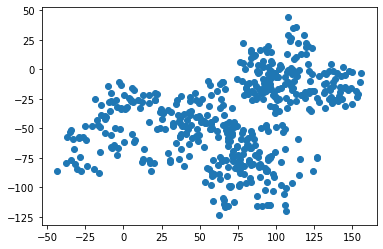

In [4]:
mh_input = MhInput()
mh_input.dimension = 2
mh_input.pdf_target = log_rosenbrock_with_param
mh_input.burn_length = 500
mh_input.jump = 50
mh_input.chains_number = 1
mh_input.args_target =(20,)

x = MetropolisHastings(mh_input=mh_input, samples_number=500)
plt.plot(x.samples[:, 0], x.samples[:, 1], 'o')
plt.show()

In the following, a custom Rosenbrock distribution is defined and its log_pdf method is used.

In [5]:
from UQpy.distributions import DistributionND

class Rosenbrock(DistributionND):
    def __init__(self, p=20.):
        super().__init__(p=p)
    def pdf(self, x):
        return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/self.parameters['p'])
    def log_pdf(self, x):
        return -(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/self.parameters['p']

In [6]:
log_pdf_target = Rosenbrock(p=20.).log_pdf

mh_input = MhInput()
mh_input.dimension = 2
mh_input.pdf_target = log_pdf_target
mh_input.burn_length = 500
mh_input.jump = 50
mh_input.chains_number = 1
mh_input.seed = None

x = MetropolisHastings(mh_input=mh_input, samples_number=500)

In the following, we show that if nburn is set to 0, the first sample is always the seed.

(250, 2, 2)


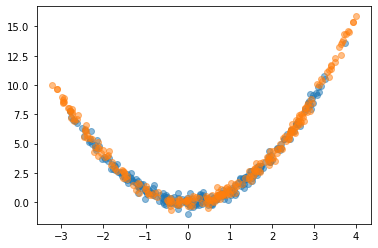

[[ 0. -1.]
 [ 1.  1.]]
[[ 0. -1.]
 [ 1.  1.]]


In [7]:
seed = np.array([[0., -1.], [1., 1.]])

mh_input = MhInput()
mh_input.dimension = 2
mh_input.log_pdf_target=log_pdf_target
mh_input.burn_length=0
mh_input.jump=50
mh_input.seed=seed
mh_input.concatenate_chains=False

x = MetropolisHastings(mh_input=mh_input, samples_number=500)
print(x.samples.shape)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', alpha=0.5)
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', alpha=0.5)
plt.show()

print(seed)
print(x.samples[0, :, :])

## The algorithm-specific parameters for MH are proposal and proposal_is_symmetric

The default proposal is standard normal (symmetric).

In [8]:
# Define a few proposals to try out
from UQpy.distributions import JointIndependent, Normal, Uniform

proposals = [JointIndependent([Normal(), Normal()]),
             JointIndependent([Uniform(loc=-0.5, scale=1.5), Uniform(loc=-0.5, scale=1.5)]),
             Normal()]

proposals_is_symmetric = [True, False, False]

0
1
2
Wrong dimension in x.
This last call fails because the proposal is in dimension 1, while the target distribution is in dimension 2


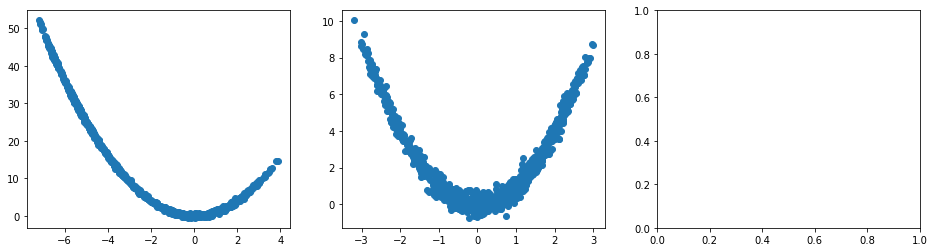

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for i, (proposal, symm) in enumerate(zip(proposals, proposals_is_symmetric)):
    print(i)
    try:
        mh_input = MhInput()
        mh_input.dimension = 2
        mh_input.burn_length=500
        mh_input.jump=100
        mh_input.log_pdf_target=log_pdf_target
        mh_input.proposal=proposal
        mh_input.proposal_is_symmetric=symm
        mh_input.chains_number=1

        x = MetropolisHastings(mh_input=mh_input, samples_number=1000)
        ax[i].plot(x.samples[:, 0], x.samples[:, 1], 'o')
    except ValueError as e:
        print(e)
        print('This last call fails because the proposal is in dimension 1, while the target distribution is'
              ' in dimension 2')
plt.show()

## Run several chains in parallel

The user can provide the total number of samples nsamples, or the number of samples per chain nsamples_per_chain.

(50, 2, 2)


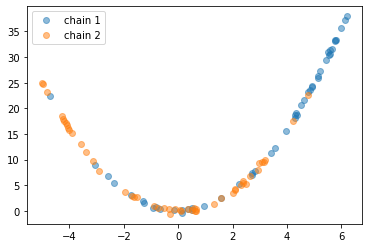

In [10]:
mh_input = MhInput()
mh_input.dimension = 2
mh_input.log_pdf_target=log_pdf_target
mh_input.jump=1000
mh_input.burn_length=500
mh_input.seed = np.array([[0., 0.], [1., 1.]])
mh_input.concatenate_chains=False

x = MetropolisHastings(mh_input=mh_input, samples_number=100)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1', alpha=0.5)
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2', alpha=0.5)
print(x.samples.shape)
plt.legend()
plt.show()

(100, 2, 2)


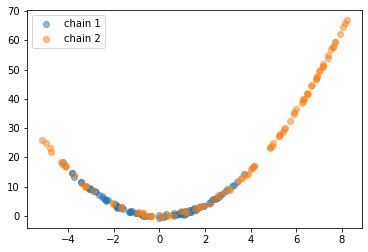

In [11]:
mh_input = MhInput()
mh_input.dimension = 2
mh_input.log_pdf_target=log_pdf_target
mh_input.jump=1000
mh_input.burn_length=500
mh_input.seed=np.array([[0., 0.], [1., 1.]])
mh_input.concatenate_chains=False

x = MetropolisHastings(mh_input=mh_input, samples_number_per_chain=100)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1', alpha=0.5)
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2', alpha=0.5)
print(x.samples.shape)
plt.legend()
plt.show()

## Initialize without nsamples... then call run

In [12]:
t = time.time()

mh_input = MhInput()
mh_input.dimension = 2
mh_input.log_pdf_target=log_pdf_target
mh_input.jump=1000
mh_input.burn_length=500
mh_input.seed=np.array([[0., 0.], [1., 1.]])
mh_input.concatenate_chains=False

x = MetropolisHastings(mh_input=mh_input)
print('Elapsed time for initialization: {} s'.format(time.time() - t))

Elapsed time for initialization: 0.0008380413055419922 s


Elapsed time for running MCMC: 8.050274848937988 s
nburn, jump at first run: 500, 1000
total nb of samples: 50


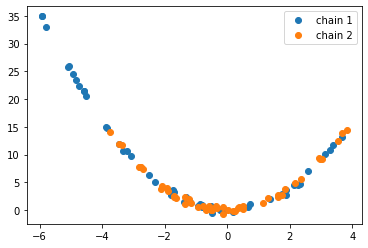

In [13]:
t = time.time()
x.run(samples_number=100)
print('Elapsed time for running MCMC: {} s'.format(time.time() - t))
print('nburn, jump at first run: {}, {}'.format(x.burn_length, x.jump))
print('total nb of samples: {}'.format(x.samples.shape[0]))

plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1')
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2')
plt.legend()
plt.show()

## Run another example with a bivariate distributon with copula dependence - use random_state to always have the same outputs

In [14]:
from UQpy.distributions import Normal, Gumbel, JointCopula, JointIndependent
dist_true = JointCopula(marginals=[Normal(), Normal()], copula=Gumbel(theta=2.))
proposal = JointIndependent(marginals=[Normal(scale=0.2), Normal(scale=0.2)])

mh_input = MhInput()
mh_input.dimension = 2
mh_input.log_pdf_target = dist_true.log_pdf
mh_input.proposal=proposal
mh_input.seed=[0., 0.]
mh_input.random_state=123


sampler = MetropolisHastings(mh_input=mh_input, samples_number=500)
print(sampler.samples.shape)
print(np.round(sampler.samples[-5:], 4))

(500, 2)
[[-0.1966  0.1831]
 [-0.2325  0.2526]
 [ 0.2104  0.0748]
 [ 0.0091  0.1651]
 [ 0.1693  0.2409]]


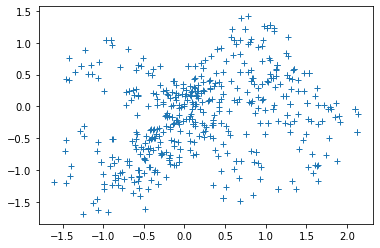

In [15]:
plt.plot(sampler.samples[:, 0], sampler.samples[:, 1], linestyle='none', marker='+')